In [4]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path


In [6]:
cats_dogs_dir = "data/task2/cats_dogs/kagglecatsanddogs_3367a/PetImages/"
food_101_dir = "data/task2/food-101/food-101/food-101/"
food101_image_dir = food_101_dir + "images/"
food101_meta_dir = food_101_dir + "meta/"

In [7]:
with open(food101_meta_dir + 'classes.txt') as f:
    food_classes = [line.rstrip() for line in f]

cats_dogs_classes = ['Cat', 'Dog']

## Feature Extraction with DenseNet and DinoV2

In [4]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    return 'cpu'
device = get_device()
print(f"Using device: {device}")

Using device: mps


In [11]:
# Initialize DenseNet121 model 
densenet_model = models.densenet121()
# Remove the classification layer to get feature extraction layer
densenet_model = nn.Sequential(*list(densenet_model.children())[:-1])
densenet_model = densenet_model.to(device)
densenet_model.eval()

densenet_transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_model = dinov2_model.to(device)
dinov2_model.eval()

dinov2_transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using cache found in /Users/nhanncv/.cache/torch/hub/facebookresearch_dinov2_main
/Users/nhanncv/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/nhanncv/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/nhanncv/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [13]:
def extract_densenet_features(image_path, model, transform, device):
    img = Image.open(image_path).convert('RGB')  # Convert grayscale to RGB in case some images has only one channel
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = model(img_tensor)
        # Apply adaptive pooling and flatten as we removed the last layer
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        features = features.view(features.size(0), -1)
    
    return features.cpu().numpy().flatten()

def extract_dinov2_features(image_path, model, transform, device):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = model(img_tensor)
    
    return features.cpu().numpy().flatten()

## Food101 Feature Extraction

In [14]:

food101_densenet_features_dict = {}
food_101_dinov2_features_dict = {}
f_labels = []


for food_cls in food_classes:
    print(f"\nProcessing class: {food_cls}")
    class_dir = Path(food101_image_dir) / food_cls
    image_files = sorted([p for p in class_dir.iterdir() if p.is_file()])
    
    densenet_features_list = []
    dinov2_features_list = []
    
    for img_path in image_files:
        try:
            # Extract DenseNet features
            densenet_feat = extract_densenet_features(img_path, densenet_model, densenet_transform, device)
            densenet_features_list.append(densenet_feat)
            
            # Extract DinoV2 features
            dinov2_feat = extract_dinov2_features(img_path, dinov2_model, dinov2_transform, device)
            dinov2_features_list.append(dinov2_feat)
            
            f_labels.append(food_cls)
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")
            continue
    
    food101_densenet_features_dict[food_cls] = np.array(densenet_features_list)
    food_101_dinov2_features_dict[food_cls] = np.array(dinov2_features_list)
    


Processing class: apple_pie

Processing class: baby_back_ribs

Processing class: baklava

Processing class: beef_carpaccio

Processing class: beef_tartare

Processing class: beet_salad

Processing class: beignets

Processing class: bibimbap

Processing class: bread_pudding

Processing class: breakfast_burrito

Processing class: bruschetta

Processing class: caesar_salad

Processing class: cannoli

Processing class: caprese_salad

Processing class: carrot_cake

Processing class: ceviche

Processing class: cheesecake

Processing class: cheese_plate

Processing class: chicken_curry

Processing class: chicken_quesadilla

Processing class: chicken_wings

Processing class: chocolate_cake

Processing class: chocolate_mousse

Processing class: churros

Processing class: clam_chowder

Processing class: club_sandwich

Processing class: crab_cakes

Processing class: creme_brulee

Processing class: croque_madame

Processing class: cup_cakes

Processing class: deviled_eggs

Processing class: donut

### Cats Dogs Feature Extraction

In [15]:

cd_densenet_features_dict = {}
cd_dinov2_features_dict = {}
cd_labels = []


for animal_cls in cats_dogs_classes:
    print(f"\nProcessing class: {animal_cls}")
    class_dir = Path(cats_dogs_dir) / animal_cls
    image_files = sorted([p for p in class_dir.iterdir() if p.is_file()])
    
    densenet_features_list = []
    dinov2_features_list = []
    
    for img_path in image_files:
        try:
            # Extract DenseNet features
            densenet_feat = extract_densenet_features(img_path, densenet_model, densenet_transform, device)
            densenet_features_list.append(densenet_feat)
            
            # Extract DinoV2 features
            dinov2_feat = extract_dinov2_features(img_path, dinov2_model, dinov2_transform, device)
            dinov2_features_list.append(dinov2_feat)
            
            cd_labels.append(animal_cls)
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")
            continue
    
    cd_densenet_features_dict[animal_cls] = np.array(densenet_features_list)
    cd_dinov2_features_dict[animal_cls] = np.array(dinov2_features_list)
    


Processing class: Cat

Processing class: Dog


/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [16]:
# Combine all features into single arrays
f_densenet_features_all = np.vstack([food101_densenet_features_dict[cls] for cls in food_classes])
f_dinov2_features_all = np.vstack([food_101_dinov2_features_dict[cls] for cls in food_classes])
f_labels_array = np.array(f_labels)

cd_densenet_features_all = np.vstack([cd_densenet_features_dict[cls] for cls in cats_dogs_classes])
cd_dinov2_features_all = np.vstack([cd_dinov2_features_dict[cls] for cls in cats_dogs_classes])
cd_labels_array = np.array(cd_labels)

print(f"\n Food101 DenseNet features shape: {f_densenet_features_all.shape}")
print(f"Food101 DinoV2 features shape: {f_dinov2_features_all.shape}")
print(f"Food101 Labels shape: {f_labels_array.shape}")

print(f"\n Cats Dogs DenseNet features shape: {cd_densenet_features_all.shape}")
print(f"Cats Dogs DinoV2 features shape: {cd_dinov2_features_all.shape}")
print(f"Cats Dogs Labels shape: {cd_labels_array.shape}")


 Food101 DenseNet features shape: (101000, 1024)
Food101 DinoV2 features shape: (101000, 384)
Food101 Labels shape: (101000,)

 Cats Dogs DenseNet features shape: (24959, 1024)
Cats Dogs DinoV2 features shape: (24959, 384)
Cats Dogs Labels shape: (24959,)


In [4]:
output_dir = Path("data/features")

In [ ]:

output_dir.mkdir(parents=True, exist_ok=True)

np.save(output_dir / "f_densenet_features.npy", f_densenet_features_all)
np.save(output_dir / "f_dinov2_features.npy", f_dinov2_features_all)
np.save(output_dir / "f_labels.npy", f_labels_array)

np.save(output_dir / "cd_densenet_features.npy", cd_densenet_features_all)
np.save(output_dir / "cd_dinov2_features.npy", cd_dinov2_features_all)
np.save(output_dir / "cd_labels.npy", cd_labels_array)

print(f"Features saved to {output_dir}/")

Features saved to data/features/


In [5]:
# load npy files so we dont need to start all over again
f_densenet_features_all = np.load(output_dir / "f_densenet_features.npy")
f_dinov2_features_all = np.load(output_dir / "f_dinov2_features.npy")
f_labels_array = np.load(output_dir / "f_labels.npy")

cd_densenet_features_all = np.load(output_dir / "cd_densenet_features.npy")
cd_dinov2_features_all = np.load(output_dir / "cd_dinov2_features.npy")
cd_labels_array = np.load(output_dir /  "cd_labels.npy")

## Scaling and Dimensionality Reduction

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time

In [7]:
# Scaling
scaler = StandardScaler()

f_densenet_features_scaled = scaler.fit_transform(f_densenet_features_all)
f_dinov2_features_scaled = scaler.fit_transform(f_dinov2_features_all)

cd_densenet_features_scaled = scaler.fit_transform(cd_densenet_features_all)
cd_dinov2_features_scaled = scaler.fit_transform(cd_dinov2_features_all)

In [8]:
output_dir = Path("data/scaled")
output_dir.mkdir(parents=True, exist_ok=True)

np.save(output_dir / "f_densenet_scaled.npy", f_densenet_features_scaled)
np.save(output_dir / "f_dinov2_scaled.npy", f_dinov2_features_scaled)

np.save(output_dir / "cd_densenet_scaled.npy", cd_densenet_features_scaled)
np.save(output_dir / "cd_dinov2_scaled.npy", cd_dinov2_features_scaled)

print(f"Scaled data saved to {output_dir}/")

Scaled data saved to data/scaled/


### Apply Dimensionality Reduction Techniques

In [9]:
import pandas as pd

reduced_features = {
    'densenet': {},
    'dinov2': {}
}

def find_optimal_pca_components(features, variance_threshold=0.95):

    n_max = min(features.shape[0], features.shape[1])
    pca = PCA(n_components=n_max, random_state=42)
    pca.fit(features)
    
    cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
    
    
    n_optimal = np.argmax(cumsum_variance >= variance_threshold) + 1
    
    print(f"Using {n_optimal} components")
    print(f"Variance explained: {cumsum_variance[n_optimal-1]:.4f}")
    
    return n_optimal

def apply_dimensionality_reduction(features, variance_threshold=0.95, max_components=100):
    start_time = time.time()
    
    n_optimal = find_optimal_pca_components(
        features, variance_threshold
    )
    
    print(f"Applying PCA: {features.shape[1]} -> {n_optimal} dimensions...")
    pca = PCA(n_components=n_optimal, random_state=42)
    reduced = pca.fit_transform(features)
    
    elapsed_time = time.time() - start_time
    print(f"Completed in {elapsed_time:.2f} seconds")
    print(f"Output shape: {reduced.shape}\n")
    pca_df = pd.DataFrame(reduced, columns=[f"PC{x}" for x in range(1, n_optimal+1 )])
    
    return reduced, pca_df

In [10]:
print("Food101 - DenseNet features:")
reduced_features['densenet']['f101'], pca_densenet_f101 = apply_dimensionality_reduction(
    f_densenet_features_scaled, variance_threshold=0.95, max_components=200
)

print("Food101 - DinoV2 features:")
reduced_features['dinov2']['f101'], pca_dinov2_f101 = apply_dimensionality_reduction(
    f_dinov2_features_scaled, variance_threshold=0.95, max_components=200
)

print("Cats & Dogs - DenseNet features:")
reduced_features['densenet']['cd'], pca_densenet_cd = apply_dimensionality_reduction(
    cd_densenet_features_scaled, variance_threshold=0.95, max_components=200
)

print("Cats & Dogs - DinoV2 features:")
reduced_features['dinov2']['cd'], pca_dinov2_cd = apply_dimensionality_reduction(
    cd_dinov2_features_scaled, variance_threshold=0.95, max_components=200
)

Food101 - DenseNet features:
Using 14 components
Variance explained: 0.9513
Applying PCA: 1024 -> 14 dimensions...
Completed in 4.62 seconds
Output shape: (101000, 14)

Food101 - DinoV2 features:
Using 202 components
Variance explained: 0.9503
Applying PCA: 384 -> 202 dimensions...
Completed in 0.26 seconds
Output shape: (101000, 202)

Cats & Dogs - DenseNet features:
Using 14 components
Variance explained: 0.9522
Applying PCA: 1024 -> 14 dimensions...
Completed in 1.61 seconds
Output shape: (24959, 14)

Cats & Dogs - DinoV2 features:
Using 197 components
Variance explained: 0.9500
Applying PCA: 384 -> 197 dimensions...
Completed in 0.07 seconds
Output shape: (24959, 197)



In [8]:
output_dir = Path("data/reduced")
output_dir.mkdir(parents=True, exist_ok=True)

In [ ]:



np.save(output_dir / "f_densenet_reduced.npy", reduced_features['densenet']['f101'])
np.save(output_dir / "f_dinov2_reduced.npy", reduced_features['dinov2']['f101'])

np.save(output_dir / "cd_densenet_reduced.npy", reduced_features['densenet']['cd'])
np.save(output_dir / "cd_dinov2_reduced.npy", reduced_features['dinov2']['cd'])

print(f"Reduced data saved to {output_dir}/")

Reduced data saved to data/reduced/


In [9]:
f_densenet_reduced = np.load(output_dir / "f_densenet_reduced.npy")
f_dinov2_reduced = np.load(output_dir / "f_dinov2_reduced.npy")

cd_densenet_reduced = np.load(output_dir / "cd_densenet_reduced.npy")
cd_dinov2_reduced = np.load(output_dir / "cd_dinov2_reduced.npy")

## Clustering

In [10]:
# Metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def compute_scores(X, labels):
    labels = np.array(labels)
    if len(np.unique(labels)) < 2:
        return dict(silhouette=np.nan, db=np.nan, ch=np.nan)

    return dict(
        silhouette = silhouette_score(X, labels),
        db         = davies_bouldin_score(X, labels),
        ch         = calinski_harabasz_score(X, labels),
    )

In [18]:
from sklearn.cluster import KMeans

def cluster_and_visualize(features, k, title, fig_path):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(features)
    scores = compute_scores(features, labels)
    
    print(f"{title} (k={k})")
    print(f"  Silhouette: {scores['silhouette']:.4f}")
    print(f"  Davies-Bouldin: {scores['db']:.4f}")
    print(f"  Calinski-Harabasz: {scores['ch']:.2f}\n")
    
    # Reduce to 2D
    pca_2d = PCA(n_components=2, random_state=42)
    features_2d = pca_2d.fit_transform(features)
    
    # Plot
    
    # Clusters
    scatter1 = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, 
                           cmap='tab20' if k > 10 else 'tab10', s=5, alpha=0.5)
    plt.title(title)
    plt.colorbar(scatter1)
    plt.savefig(fig_path)
    plt.tight_layout()
    plt.show()
    
    return labels, scores

Food101 - Densenet-121 K-Means clustering with k = 101 (k=101)
  Silhouette: 0.0996
  Davies-Bouldin: 1.6104
  Calinski-Harabasz: 5729.94



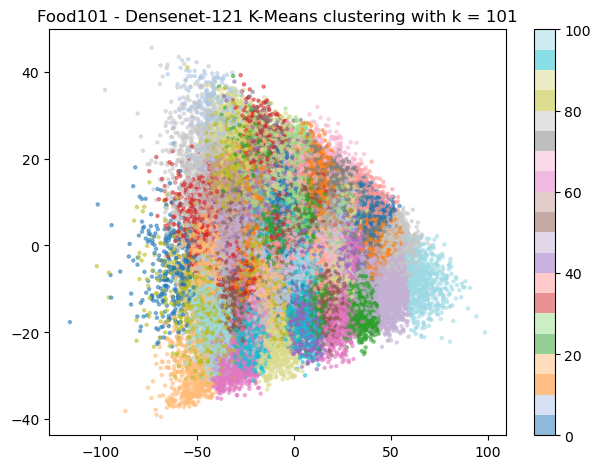

(array([70, 49, 99, ..., 52, 82, 42], shape=(101000,), dtype=int32),
 {'silhouette': 0.09959902614355087,
  'db': 1.6103508888584221,
  'ch': 5729.93896484375})

In [20]:
cluster_and_visualize(f_densenet_reduced, 101, "Food101 - Densenet-121 K-Means clustering with k = 101", 'images/f101-densenet-kmeans-clustering.png')

Food101 - DINOV2 K-Means clustering with k = 101 (k=101)
  Silhouette: 0.0904
  Davies-Bouldin: 2.6753
  Calinski-Harabasz: 888.37



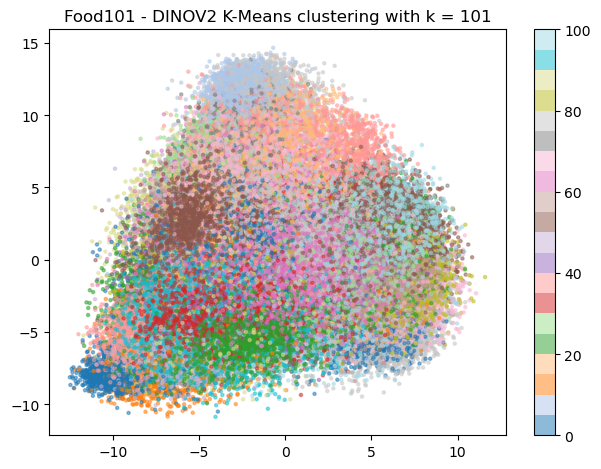

(array([85, 64,  2, ..., 50, 50, 50], shape=(101000,), dtype=int32),
 {'silhouette': 0.09042158722877502,
  'db': 2.675285991718448,
  'ch': 888.3651123046875})

In [24]:
cluster_and_visualize(f_dinov2_reduced, 101, "Food101 - DINOV2 K-Means clustering with k = 101", 'images/f101-dinov2-kmeans-clustering.png')

Cats vs. Dogs - DensenNet-121 K-Means clustering with k = 2 (k=2)
  Silhouette: 0.3468
  Davies-Bouldin: 1.0796
  Calinski-Harabasz: 18609.98



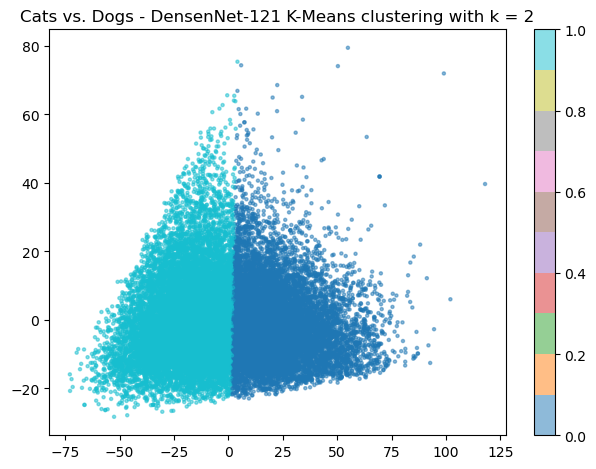

(array([0, 0, 1, ..., 0, 1, 1], shape=(24959,), dtype=int32),
 {'silhouette': 0.3467613756656647,
  'db': 1.0795733013903228,
  'ch': 18609.9765625})

In [23]:
cluster_and_visualize(cd_densenet_reduced, 2, "Cats vs. Dogs - DensenNet-121 K-Means clustering with k = 2", 'images/cd-densenet-kmeans-clustering.png')

Cats vs. Dogs - DINOV2 K-Means clustering with k = 2 (k=2)
  Silhouette: 0.0973
  Davies-Bouldin: 3.0443
  Calinski-Harabasz: 2671.85



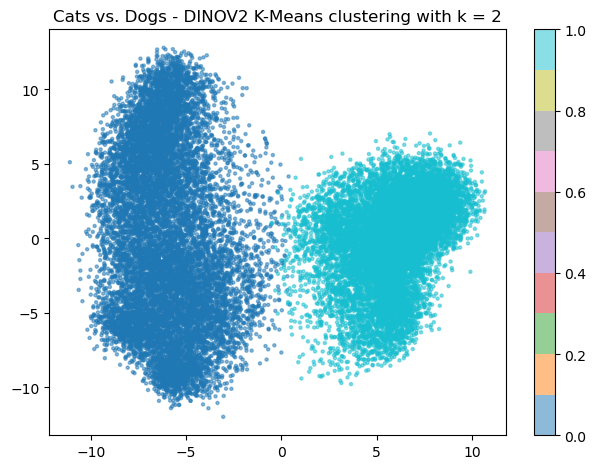

(array([0, 0, 0, ..., 1, 1, 1], shape=(24959,), dtype=int32),
 {'silhouette': 0.09730324149131775,
  'db': 3.044297942603565,
  'ch': 2671.846923828125})

In [25]:
cluster_and_visualize(cd_dinov2_reduced, 2, "Cats vs. Dogs - DINOV2 K-Means clustering with k = 2", 'images/cd-dinov2-kmeans-clustering.png')